#### **專案一**: 卷積神經網路(CNN)分析



姓名：張子恩 
<hr>

 <font color=steelblue>**作業目標**</font>
  <br>
  
利用 PyTorch 卷積神經網路 CNN 模型進行 Yale Face 人臉辨識。其中 CNN 模型與訓練等相關參數自行設定，盡量達到測試資料的辨識準確率最高為目的。最後並寫一段程式實際對已訓練完成的 CNN 模型（讀入 pre-trained pth 檔）輸入任何多張測試影像，並列印出所辨識人臉的 Label。

<hr>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.io
import matplotlib.pyplot as plt
import torchvision

此為本題CNN模型架構，特別要注意的是shape的計算，需要注意padding、kernal_size、stride以及pooling和進入全輸出層的計算。  
模型結構：  
1. **第一個卷積層和池化**
   - 使用 6 個 5x5 的卷積核，經過 ReLU 激活函數後，進行 2x2 的最大池化。

2. **第二個卷積層和池化**
   - 使用 16 個 5x5 的卷積核，經過 ReLU 激活函數後，進行 2x2 的最大池化。

3. **展平**
   - 將多維張量展平成一維張量，以便進入全連接層。

4. **第一個全連接層**
   - 經過 120 個神經元的全連接層，使用 ReLU 激活函數，並進行 Dropout（丟棄率 0.3）。

5. **第二個全連接層**
   - 經過 84 個神經元的全連接層，使用 ReLU 激活函數，再次進行 Dropout（丟棄率 0.3）。

6. **輸出層**
   - 最後經過 38 個神經元的全連接層，得到最終輸出。


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 1 input channel, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # 6 input channel, 16 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 39 * 45 , 120)  # 16 channels, 4x4 image dimension after max pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 38)  # 38 output classes
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # First convolutional layer followed by ReLU activation and max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        # Second convolutional layer followed by ReLU activation and max pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)) # First fully connected layer with ReLU activation
        x = self.dropout(x)   
        x = F.relu(self.fc2(x))  # Second fully connected layer with ReLU activation
        x = self.dropout(x)   
        x = self.fc3(x)          # Output layer without activation
        return x

In [5]:
model = CNN()


PATH = 'C:/vscode\淺度hw4/hw4_CNN.pt'

model.load_state_dict(torch.load(PATH))

model.eval()

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=38, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

#### **討論**  
接著讀取先前練好的模型權重，需要注意的是要測試資料時需要先打上model.eval()(評估模式)，以免後執行時權重發現變化，反之要進行修改時，則打上model.train()(訓練模式)。

In [3]:

D = scipy.io.loadmat("C:/vscode/淺度hw3練習/allFaces.mat")
m = int(D['m'])#168
n = int(D['n'])#192
X = D["faces"]
y= np.ndarray.flatten(D["nfaces"])

# X = D["faces"]
target = []
#設置標籤
for i in range(y.shape[0]):
     for j in range(y[i]):
        target.append(i)
target= np.array(target,dtype="int32")


test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X.T, target, test_size=test_size,random_state=0) # deafult test_size=0.2
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = torch.from_numpy(X_train).float()
X_train = X_train.reshape(-1,1,168,192)
y_train = torch.from_numpy(y_train).long()

train_dataset = TensorDataset(X_train,y_train)


X_test = torch.from_numpy(X_test).float()
X_test = X_test.reshape(-1,1,168,192)
y_test = torch.from_numpy(y_test).long()
test_dataset = TensorDataset(X_test,y_test)

batch_size = 128
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size= batch_size,shuffle=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_8688\665342201.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(D['m'])#168
C:\Users\USER\AppData\Local\Temp\ipykernel_8688\665342201.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(D['n'])#192


#### **討論**  
這邊為隨機抽取圖片放入測試，為了方便直接分成測試集以及訓練集。

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
correct = 0
total =0 
with torch.no_grad():
    for data in test_loader:
        images,labels = data[0].to(device),data[1].to(device)
        outputs = model(images)
        _,predicted  = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the {len(test_dataset)} test images: {100 * correct // total} %')

Accuracy of the network on the 723 test images: 94 %


#### **討論**  
抽取測試集圖片放入測試，準確率有94%，但要注意的是，先前訓練模型時的測試資料與訓練資料與此次不同，所以此次測試資料可能有些當時的訓練資料。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


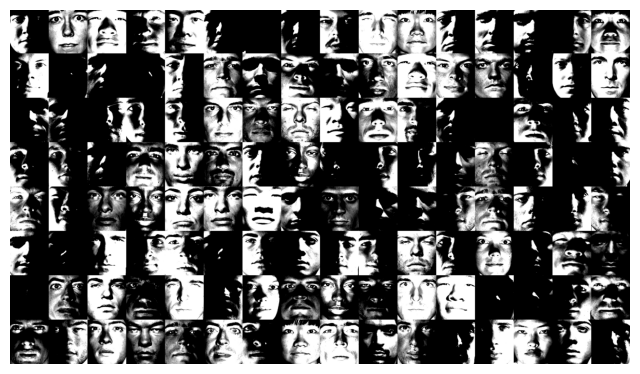

The predictions:
 tensor([[30, 32, 12,  2,  1, 14, 25, 31, 19,  9,  4, 13,  9,  8, 33,  4],
        [14, 22, 24, 28, 13, 17, 17, 14, 37, 11, 12, 14,  6, 10, 26,  9],
        [34, 12,  0, 32,  9, 21, 36,  0, 12, 34,  8,  9, 35, 27,  4,  1],
        [17,  6,  0, 37, 23,  8,  5, 20, 26, 16,  2, 33,  0, 15, 30, 18],
        [ 0, 12, 16, 20, 13, 16, 12, 29, 29, 17, 28, 36, 17, 28, 23, 36],
        [37, 35,  9, 10, 27, 14, 24, 22, 37, 37,  0, 13, 26, 22, 12, 33],
        [35,  5, 24,  7,  9,  3, 26,  3, 20, 36,  9, 12, 31, 14, 37,  2],
        [23, 36, 22, 36, 17,  5, 16,  4, 27,  8, 23,  8, 23, 25, 22,  7]],
       device='cuda:0')
labels.dim: 1
Accuracy of the network on the 64 test images: 94.53125 %


In [15]:

sample_idx = torch.randint(len(test_loader),size=(1,)).item()
# print(sample_idx)
dataiter = iter(test_loader)
s =0
for i in range(sample_idx):
    images,labels = next(dataiter)
    s=s+1
    images_ = np.transpose(images,(0,1,3,2))
    # print(images.shape)

nrow =16
montage = torchvision.utils.make_grid(images_ , nrow=nrow ,normalize=False, padding=0)
# print(montage.shape) #(channels, grid_height, grid_width)
# print((np.transpose(montage,(1,2,0)).shape))
plt.figure(figsize=(8, 6))
plt.imshow(np.transpose(montage,(1,2,0)) )
plt.axis("off")
plt.show()

outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print("The predictions:\n", predicted.reshape(images.size(0) // nrow, nrow))
print('labels.dim:',labels.dim())
total = labels.size(0)
correct_rate = (predicted == labels.to(device)).sum().item() / total
print(f'Accuracy of the network on the 64 test images: {100 * correct_rate} %')

#### **討論**  
隨機抽取test_loader中的一批次圖片放入測試，接著把圖列印出來以及預測的label與列印出來，準確率有94%。